# eCommerce behavior data from multi category store
This dataset contains 285 million users' events from eCommerce website

[**Dataset**: eCommerce behavior data from multi category store](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)

**More datasets**
Due to Kaggle's limit to max 20Gb of files per dataset, I can' upload more data to this dataset. [Here you can find additional archives (Dec 2019 - Apr 2020)](https://drive.google.com/drive/folders/1Nan8X33H8xrXS5XhCKZmSpClFTCJsSpE).

**Group Lab**


1.   NURARISSA DAYANA BINTI MOHD SUKRI A20EC0120
2.   SAKINAH AL'IZZAH BINTI MOHD ASRI A20EC0142



Installing packages

In [ ]:

!pip install squarify
!pip install statsmodels
!pip install seaborn
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nurarissadayana","key":"873d54d89b02787fd07541f2784873aa"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ecommerce-behavior-data-from-multi-category-store.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip ecommerce-behavior-data-from-multi-category-store.zip

Archive:  ecommerce-behavior-data-from-multi-category-store.zip
replace 2019-Nov.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace 2019-Oct.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


importing libraries

In [ ]:

import numpy as np 
import pandas as pd 
import os
from statsmodels import api as sm
import pylab as py
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import squarify
from scipy.stats import kstest,norm
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
from scipy.stats import chi2_contingency

## Reduce memory usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

Please enter the file location and name.

In [ ]:
df = pd.read_csv('2019-Nov.csv')
df=reduce_mem_usage(df)

Memory usage after optimization is: 2039.40 MB
Decreased by 19.4%


In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.0000,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.7500,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.3125,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,713.0000,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.2500,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36870132 entries, 0 to 36870131
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int32  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float16
 7   user_id        int32  
 8   user_session   object 
dtypes: float16(1), int32(2), int64(1), object(5)
memory usage: 2.0+ GB


## Column

In [ ]:
#no of rows with null values
print("category_code ",df['category_code'].isnull().sum())
print("brand ",df['brand'].isnull().sum())
print("Both ",(df['category_code'].isnull() & df['brand'].isnull()).sum())

category_code  11762704
brand  5115304
Both  3097076


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(23089197, 9)

## No of visitors by date
To analyze the number of visitors by date we have grouped the dataset by columns event_time and user_id.

The no.of visitors on each date is extracted and shown in the graph below.

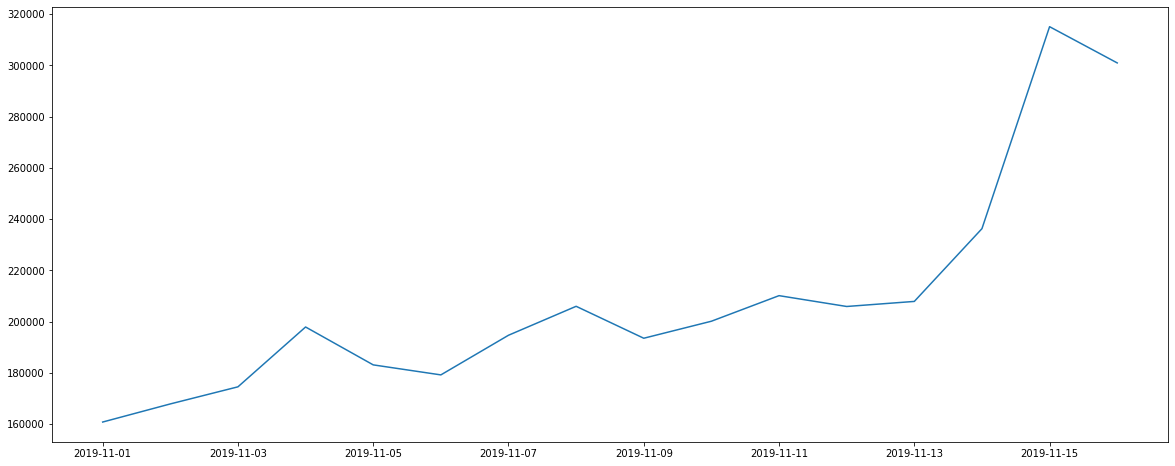

In [ ]:
#No of visitors by date
data = df.loc[:,['event_time','user_id']]
#Extracting only dates
data['event_time'] = data['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = data.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(x,y)
plt.show()

## Most bought brand


In [ ]:
df['brand'].value_counts()
df['event_type'].value_counts()

view        21725663
cart         1087427
purchase      276107
Name: event_type, dtype: int64

            event_time  event_type  product_id  category_id  category_code  \
brand                                                                        
a-elita            132         132         132          132            132   
aardwolf           216         216         216          216            216   
abtoys              53          53          53           53             53   
accumaster          16          16          16           16             16   
acd                 27          27          27           27             27   
...                ...         ...         ...          ...            ...   
zorg                60          60          60           60             60   
zotac              393         393         393          393            393   
zte               5728        5728        5728         5728           5728   
zubr              4204        4204        4204         4204           4204   
zwerg               13          13          13           13     

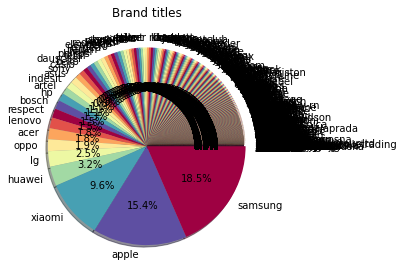

In [ ]:
title_type = df.groupby('brand').agg('count')
print(title_type)
type_labels = title_type.user_id.sort_values().index
type_counts = title_type.user_id.sort_values()
plt.figure(1,figsize =(20,10))
the_grid = GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0,1,8)]
plt.subplot(the_grid[0,1],aspect=1,title = 'Brand titles')
type_show_ids = plt.pie(type_counts,labels = type_labels,autopct = '%1.1f%%',shadow = True,colors = colors)
plt.show()

## Popular product categories
A squarify plot is used to visually represent which categories of product has drawn more demand from customer.

Most of the items are given two category codes separated by a point.First word depicts the main category of the item whereas the following word depicts its sub category.

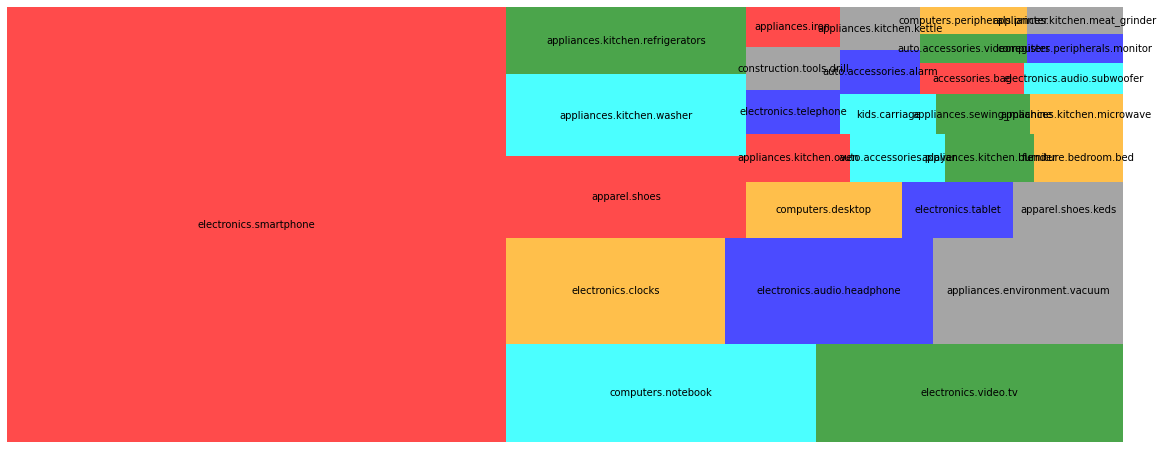

In [ ]:
top_category_n = 30
top_category = df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show()

"Smartphones" which comes under electronics goods are more popular.

A huge fraction of items bought are electronics which concludes there have been major discounts and price deals available on ecommerce platform.

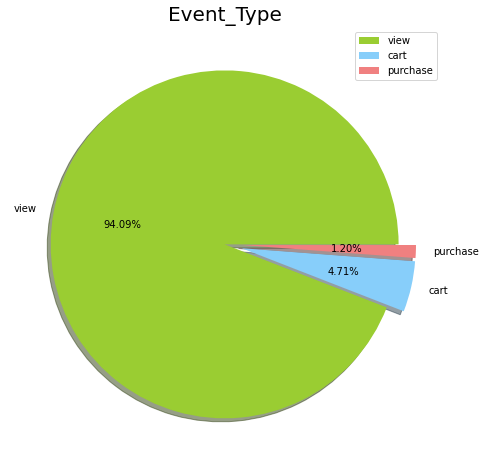

In [ ]:
labels = ['view', 'cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

## Conversion Rates
We have three type of events view,add to cart and purchase.Not every user view ,add it to the cart and purchase it.Most users tend to have look at the product and its price.

Conversion rates gives us the idea of how many users actually purchased the product as opposed to how many times the products are viewed or added to the cart.

How many products are actually purchased as opposed to number of products added to the cart.

We find

1.Count of people who viewed the item.

2.Count of people who added the item to cart.

3.Count of people who bought the item.

In [ ]:
view_count = df['event_type'].value_counts()[0]
cart_count = df['event_type'].value_counts()[1]
purchase_count = df['event_type'].value_counts()[2]
print("Rate of conversion between view and purchase events" +str((purchase_count/view_count)*100) +'%')
print("Rate of conversion between view and add to cart events" +str((cart_count/view_count)*100) +'%')
print("Rate of conversion between add to cart and purchase events" +str((purchase_count/cart_count)*100) +'%')

Rate of conversion between view and purchase events1.2708795123996908%
Rate of conversion between view and add to cart events5.005264971660474%
Rate of conversion between add to cart and purchase events25.39085382283133%


## Brandwise sales of all event types¶


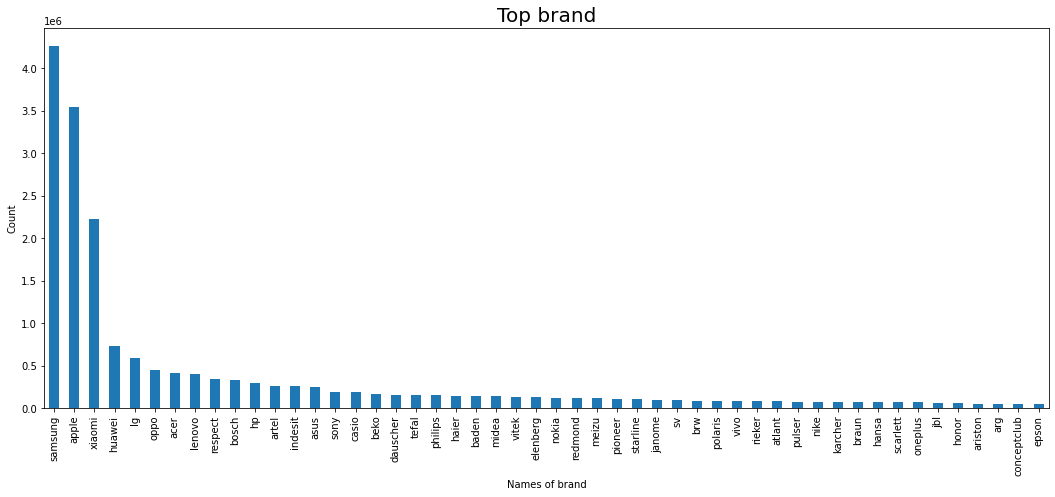

In [ ]:
#Brandwise sales of all event types
df['brand'].value_counts().head(50).plot.bar(figsize = (18,7))
plt.title('Top brand',fontsize = 20)
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

We consider only purchase events which tells us which brand is the first player in the market

samsung      85383
apple        73133
xiaomi       22717
huawei        9846
oppo          6365
             ...  
acron            1
schwinn          1
dsp              1
niio             1
schneider        1
Name: brand, Length: 976, dtype: int64


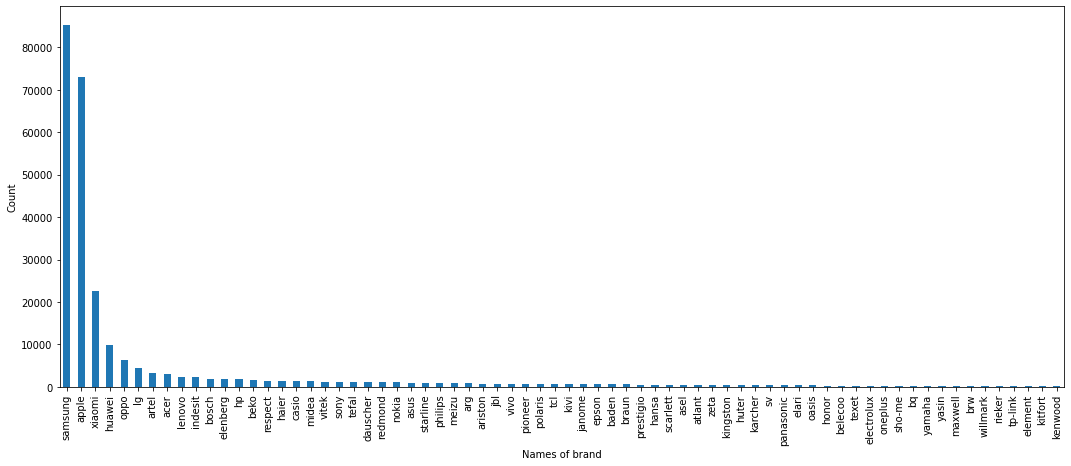

In [ ]:
d = df.loc[df['event_type'].isin(['purchase'])].drop_duplicates()
print(d['brand'].value_counts())
d['brand'].value_counts().head(70).plot.bar(figsize =(18,7))
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show()

In [ ]:
top_player = df['brand'].value_counts()[0]
second_player = df['brand'].value_counts()[1]
last_player = df['brand'].value_counts()[-1]
print("Top brand saw " +str((top_player/second_player)*100)+"%more sales than second_player in the market")
print("Top brand saw " +str((top_player/last_player)*100)+"%more sales than bottom player in the market")

Top brand saw 120.17604885416308%more sales than second_player in the market
Top brand saw 426329100.0%more sales than bottom player in the market


## Purchase path
The standard idea is that most people first view an item,compare with other item and add to cart to buy specific item.not many people follow this path.

Given below is an example of customer who followed the path view->cart->purchase

In [ ]:
df.loc[df.user_session =="ef3daa59-4936-43e5-a530-32902f64b2f4"].sort_values(by = "event_time")

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
2169,2019-11-01 00:14:32 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2275,2019-11-01 00:15:10 UTC,cart,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2309,2019-11-01 00:15:23 UTC,purchase,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4
2374,2019-11-01 00:15:46 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518840496,ef3daa59-4936-43e5-a530-32902f64b2f4


## User's journey
The code below shows the user who purchased a apple product after which he views other products manufactured by the same company "apple".

In [ ]:
user_ID = 518267348
df.loc[df['user_id'] == user_ID]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1748,2019-11-01 00:11:48 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
1822,2019-11-01 00:12:16 UTC,cart,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
1951,2019-11-01 00:13:10 UTC,purchase,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,61f913b1-ed5f-4495-8139-7e3e20be92c3
2285,2019-11-01 00:15:14 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,af95bb12-1956-40a4-a703-fcae492b2fb6
2520,2019-11-01 00:16:46 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2678,2019-11-01 00:17:47 UTC,view,1005129,2053013555631882655,electronics.smartphone,apple,1337.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2706,2019-11-01 00:17:57 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2800,2019-11-01 00:18:32 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2868,2019-11-01 00:18:57 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464
2875,2019-11-01 00:19:00 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.0,518267348,4a1fa3dc-f7ed-4880-8e86-9b9f87045464


## Chunksize = 10000

In [ ]:
df = pd.read_csv('2019-Nov.csv', chunksize=100000)

In [ ]:
output = pd.DataFrame()
for chunk in df:
    categories = ['brand','category_code','event_type']
    details = chunk[categories]
    details['count'] = 1
    summary = details.groupby(categories).sum().reset_index()
    output = output.append(summary, ignore_index=True)

<ipython-input-30-4a6757a265a1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  details['count'] = 1


In [ ]:
final_output = output.groupby(categories).sum().reset_index()

In [ ]:
final_output.to_csv('aggregated-consumer-info-2019-Nov.csv', index=False)